In [36]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
print("Done")

Done


In [29]:
# Define the dataset directory
dataset_dir = "/kaggle/input/google-speech-commands"

# Define the directories for each digit in the dataset
digits = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
digit_dirs = [os.path.join(dataset_dir, digit) for digit in digits]

# List to store MFCCs and labels
dataset = []
labels = []
print("Done")

Done


In [30]:
# Loop through directories for digits from zero to nine
for digit_dir in digit_dirs:
    digit = os.path.basename(digit_dir)
    for file_name in tqdm(os.listdir(digit_dir), desc=f"Processing {digit}"):  
        if file_name.endswith(".wav"):
            audio_file_path = os.path.join(digit_dir, file_name)
            audio_data, sample_rate = librosa.load(audio_file_path)
            
            # Compute log-mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128, fmax=8000)
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            
            # Resize the spectrogram to a fixed length (e.g., 128 frames)
            if log_mel_spectrogram.shape[1] < 128:
                log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, 128 - log_mel_spectrogram.shape[1])), mode='constant')
            else:
                log_mel_spectrogram = log_mel_spectrogram[:, :128]
            
            # Reshape the spectrogram to match the input shape of the model
            log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)
            
            dataset.append(log_mel_spectrogram)
            labels.append(digit)

print("Done")


Processing nine: 100%|██████████| 2364/2364 [00:47<00:00, 49.42it/s]

Done


In [31]:
# Convert to numpy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Shuffle the dataset
dataset, labels = shuffle(dataset, labels)

In [32]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Done")

Done


In [33]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# Normalize the input features (z-score normalization)
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Reshape the input data to match CNN input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.1222 - loss: 2.3889 - val_accuracy: 0.1136 - val_loss: 2.3474 - learning_rate: 0.0010
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1725 - loss: 2.2306 - val_accuracy: 0.2264 - val_loss: 2.1245 - learning_rate: 0.0010
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2172 - loss: 2.1276 - val_accuracy: 0.3040 - val_loss: 1.9300 - learning_rate: 0.0010
Epoch 4/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2656 - loss: 2.0157 - val_accuracy: 0.3498 - val_loss: 1.8276 - learning_rate: 0.0010
Epoch 5/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2976 - loss: 1.9467 - val_accuracy: 0.3627 - val_loss: 1.7826 - learning_rate: 0.0010
Epoch 6/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3166 - loss: 1.8923 - val_accuracy: 0.3762 - val_loss: 1.7204 - learning_rate: 0.0010
Epoch 7/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3401 - loss: 

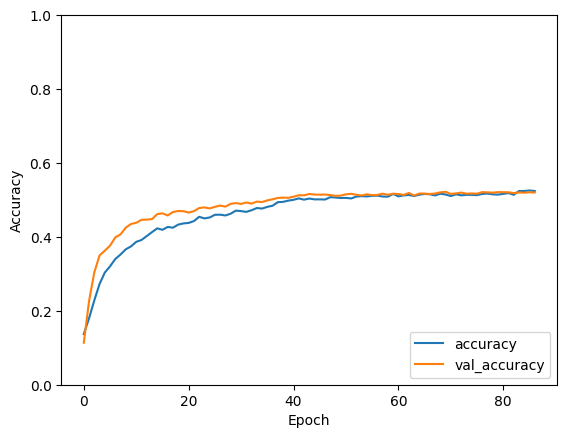

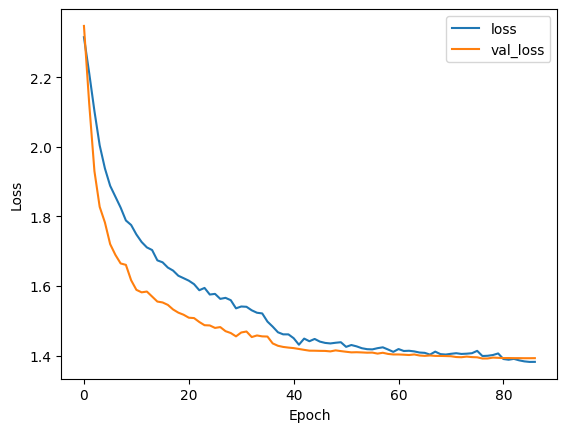

In [39]:
# Define CNN model
model = Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.Conv1D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()